# SDSS eBOSS Data 
## Script on reading and pre-processing data, and generation of a catalogue of desirable galaxy types

This script extracts useful data from the spPlate and spAll_redrock fits files, and generates the required training data set.

Note: all functions used are put together in the code cell preceeding the execution cell.

1. **Defining input parameters**
2. **Reading and pre-processing the data**
3. **Applying selection cuts** <br>
   3.1 **Selecting common wavelengths**
5. **Generating the training data set**
5. **Histograms showing the samples for every type of target**

**Data**: 14th Oct, 2019. <br>
**Author**: Soumya Shreeram <br>
**Supervised by**: Anand Raichoor <br>
**Script adapted from**: S. Ben Nejma


In [2]:
import astropy.io.fits as fits
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import numpy as np
from numpy.lib.format import open_memmap
import os
import subprocess
from astropy.convolution import convolve, Box1DKernel

## 1. Defining input parameters

In [17]:
# data directory on lesta with the spAll_redrock files
spPlate_dir = r'/hpcstorage/raichoor/spplatelist_v5_13_0/spPlate'
spAll_redrock_file = r'/hpcstorage/raichoor/spplatelist_v5_13_0/' \
            'spall_redrock_v5_13_0.valid.fits'

# number of plates of ELGs, LRG+QSOs, and Boss plates to select
num_pl = 400

# return info about selected fibres?
return_infos = True

# select corrupted or uncorrunpter samples?
uncorrupted = False

# minimum - maximum wavelengths considered
wmin, wmax = 3700, 10000

# save all the fibre-ids for the selected plates in the file info.npy?
return_infos=True

## 2. Reading the data

In [18]:
def setName(data_dir, plate_mjd):
    file_name = data_dir+'-'+plate_mjd+'.fits'
    return file_name

def readFile(filename):
    """
    Function opens the file
    @input filename :: name of the file
    """
    hdu = fits.open(filename)
    data = hdu[1].data
    hdu.close()        
    return data

def plateMJD(data):
    # defining the PLATE number, p, and MJD, m for all the files
    pms = np.array([str(p)+'-'+ str(m) for p, m in zip(data['PLATE'],
data['MJD'])])
    return pms

def uniquePmsProgramme(pms, data):
    # selecting only the unique plates-mjd, and find their programmes
    pms_unique, idx = np.unique(pms, return_index=True)
    prog_unique = data['programname'][idx]
    return pms_unique, prog_unique

def applyWaveCuts(w, wmin, wmax):
    idx = np.where((w>wmin) & (w<wmax))
    return w[idx], idx      

def readSpPlate(data_dir, plate_mjd, wmin, wmax):
    """
    Function to read the useful headers and data from spPlate fits file
    @param place :: 4-digit plate number
    @param mjd :: 5-digit MJD
    
    @returns wavelength, bunit, flux, ivar (refer comments for individual meanings)
    """
    # opens the file
    hdu     = fits.open(setName(data_dir, plate_mjd))        
        
    c0      = hdu[0].header['coeff0']   # Central wavelength (log10) of first pixel
    c1      = hdu[0].header['coeff1']   # Log10 dispersion per pixel
    npix    = hdu[0].header['naxis1']   # WIDTH (TOTAL!
    wavelength    = 10.**(c0 + c1 * np.arange(npix))
    bunit   = hdu[0].header['bunit']    # Units of flux

    flux    = hdu[0].data               # Flux in units of 10^-17^ erg/s/cm^2^/Ang
    ivar    = hdu[1].data               # Inverse variance (1/sigma^2^) for HDU 0
    hdu.close()
    
    # do cuts on wavelength
    wavelength, widx = applyWaveCuts(wavelength, wmin, wmax)
        
    return wavelength, widx, bunit, flux, ivar

def writeToFile(pms, outfilename, selected_plates, username):
    """
    Function extracts the info from desired files and writes to a new file
    @param pms :: complete array of plate nos. and MJD
    @param outfilename :: output file name
    @param selected_plates :: array of all the selected plates
    """    
    # extract those plate-mjd files
    extract_files = np.in1d(pms, selected_plates)
    output = outfilename+username
    
    # write info to new fits file
    hdu[1].data = hdu[1].data[extract_files]
    return hdu.writeto(outfilename, overwrite=True)

def writeOutputToFile(input_name, shape_arr, in_dtype):
    """
    Write to a .npy file as a memory-mapped array
    @param input_name :: array name
    @param shape_arr :: shape of the array to be memory-mapped
    
    @return output_arr :: the memory-mapped array
    """
    filename = 'Data_files/'+input_name+'.npy'
    w1 = open_memmap(filename, dtype=in_dtype, mode='w+', shape=shape_arr)
    return w1

## 3. Applying selection cuts

The functions below implement various selection cuts to obtain the desired data. They are summarized below:
* Select plates that observe **E**mission-**L**ine type **G**alaxies (ELGs), LRGs, and QSOs
* Select wavelength that are common to all plates
* Removing sky spectra and certain configurations
* Select redshift range (Zspec fibres)

In [19]:
def galaxyType(pms_unique, prog_unique, names, gal_type, num_p):
    """
    Function chooses the file name based of desired galaxy type
    @params pms_unique, prog_unique :: unique array of plate nos.-MJD & programmes
    @param names :: array of names of the galaxies/programmes to select/de-select
    @param gal_type :: string to distinguish the desired operations
    @param num_p :: number of plates of each galaxy to select
    
    @returns sub_plates :: bool indicies of selected plates within pms unique
    """
    if gal_type == 'ELG': # select ELG plates
        sub_plates = np.random.choice(pms_unique[(prog_unique==names[0]) | \
                                    (prog_unique==names[1])],size=num_p).tolist()
    elif gal_type == 'LRG+QSO': # select LRG+QSO plates
         sub_plates = np.random.choice(pms_unique[(prog_unique==names[0]) & \
                                            (prog_unique!=names[1]) & \
                                            (prog_unique!=names[2])],size=num_p).tolist()
    else: # select boss plates
        sub_plates = np.random.choice(pms_unique[(prog_unique==names[0])],size=num_p).tolist()    
    return np.in1d(pms_unique, sub_plates)

    
def selectPlates(pms_unique, prog_unique, num_pl):
    """
    Function the selects plates containing ELGs, LRG+QSOs, and some random.
    @param pms_unique :: arroy of plate nos. and MJDs
    @param prog_unique :: list of unique programmes (eBoss/Boss)
    @param num_pl :: number of plates of each category to select
    
    @returns selected_plates :: array of the file names containing desired galaxies
    """
    selected_plates = np.zeros(len(pms_unique), dtype = bool)
    
    # select <<num_pl>> eboss ELG plates
    names_elg = ['ELG_NGC', 'ELG_SGC']
    selected_plates |= galaxyType(pms_unique, prog_unique, names_elg, 'ELG', num_pl)
    
    # select <<num_pl>> eboss LRG+QSO plates
    names_lrgQso = ['eboss', 'ELG_NGC', 'ELG_SGC']
    selected_plates |= galaxyType(pms_unique, prog_unique, names_lrgQso, 'LRG+QSO', num_pl)
    
    # select <<num_pl>> random boss plates
    names_boss = ['boss']
    selected_plates |= galaxyType(pms_unique, prog_unique, names_boss, 'boss plates', num_pl)
    
    return selected_plates

def discardSkySpectra(data):
    """
    Function derfines the conditions for discarding the sky spectra
    and some othe factors
    """
    data = data[(data['ZWARN'] == 0) & \
                (data['OBJTYPE'] != 'SKY') & \
                (data['CHI2']/data['NPIXELS'].astype(float) > 0.4) & \
                (data['DELTACHI2']/data['NPIXELS'].astype(float) > 0.0025) &\
                (data['OBJTYPE'] != 'SPECTROPHOTO_STD')] # deletes stars - flux cal.  
    return data


def selectCommonWaves(pms_unique, spPlate_dir, wmin, wmax):
    """
    Function keeps common wavelengths observed in all files in range [wmin, wmax] 
    returns:
    @npix :: no. of pixels == length of wavelengths selected
    @delta :: difference between selected wavelengths in all files
            => must be ~0 to be sure we are selecting same wavelengths
    @w :: wavelengths selected between [wmin, wmax]
    @wave_indicies_2D :: 2D-array of wavelength indicies for all the files
    """
    npix, delta = [], []
    for i, pm in enumerate(pms_unique):
        if i == 0:
            # wavelength saved from 1st file
            w_0, idx, _, _, _ = readSpPlate(spPlate_dir, pm, wmin, wmax)        
            npix.append(len(w_0)) 
            delta.append(0) 
            # generating 2D array to save indicies of selected waves
            wave_indicies2D = np.empty((0, len(idx[0][:])))
        else:
            w, idx, _, _, _ = readSpPlate(spPlate_dir, pm, wmin, wmax)       
            npix.append(len(w))
            delta.append(np.unique(np.abs(w-w_0)).max())
            
        # saving the incidies of selected waves for all files
        wave_indicies2D = np.append(wave_indicies2D, [idx[0][:]], axis=0)            
    return npix, delta, w, wave_indicies2D

In [ ]:
# reads the file spAll_redrock and generates arrays of unique plate-MJD and programs
data = readFile(spAll_redrock_file)

# sky spectra and other factors taken out
data = discardSkySpectra(data)
pms = plateMJD(data)

# find unique pms, programmes
pms_unique, prog_unique = uniquePmsProgramme(pms, data)

# select plates containing ELGs, LRGs, QSOs, and some boss plates
keep = selectPlates(pms_unique, prog_unique, num_pl)
pms_unique, prog_unique = pms_unique[keep], prog_unique[keep]

# print the selected plates
print("Plate-MJD  | Programme")
for pm, prog in zip(pms_unique, prog_unique):     
    print(pm, " | ", prog)

### 3.1  Saves common wavelengths

In [21]:
# applies cuts on wavelengths, and stores all the indicies of selected wavelengths
npix, delta, wave, wave_indicies = selectCommonWaves(pms_unique, spPlate_dir, wmin, wmax)

# print some info        
print("Total no. of unique wavelengths, ω = %.1f.\
      \nMax. difference in wavelegths between the %d files Δω = %1.2e"%(np.unique(npix),len(pms_unique),np.max(delta)))
print("\nShape of wavelength indicies for %d files:"%len(pms_unique), np.shape(wave_indicies))

# saves the wavelength in a memory-mapped array
w = writeOutputToFile('wavelength', np.shape(wave), 'float32')
w[:] = wave
del w

Total no. of unique wavelengths, ω = 4317.0.      
Max. difference in wavelegths between the 938 files Δω = 1.09e-11

Shape of wavelength indicies for 938 files: (938, 4317)


## 4. Generating the training data sets

In [22]:
def listOfFilenamesIDs(data, pms, return_infos, pms_unique):
    """
    Function generates list of filenames with their fibre IDs for all selected fibres
    @param data :: data from the spAllRedrock fiel
    @param pms :: plate no. MJD info array of the spPlate files
    @param return_infos :: if True saves all info to npy file
    @param pms_unique :: list of unique selected pms files
    
    Returns:
    @fibre_ids :: fibre-ids for all fibres in selected plates
    @nb_fibres :: total number of selected fibres accross all plates
    """   
    # list of fibre ids for selected files
    fibre_ids = np.array([np.array(data[pms == pl_mjd]['FIBERID']-1) for pl_mjd in pms_unique])

    # generating the pms array for the selected plates
    nb_fibre, new_pms = 0, []
    for i in range(len(pms_unique)):
        nb_fibre += len(fibre_ids[i][:])
        filename = (len(fibre_ids[i][:]))*[pms_unique[i]]
        new_pms = np.concatenate((new_pms, filename), axis=0)   
    
    # saves the above info to a memory mapped array
    if return_infos:
        info = writeOutputToFile('info', (nb_fibre, 2), '<U30')
        info[:,0] = new_pms
        info[:,1] = np.array([str(f) for fibres in fibre_ids for f in fibres])        
        del info
    return fibre_ids, nb_fibre

def fileNameMaps(uncorrupted, nb_fibers, len_waves):
    """
    Names the files based on the samples to distinguish between classification and detection 
    @param uncorrupted :: bool stating the nature of the sample 
    @param nb_fibres :: total no. of selected fibres accross all plates
    @wave_idxs :: length of array of wavelengths selected
    
    Returns:
    @x_name, y_name :: name of the output file based on nature of sample
    """
    if uncorrupted:
        x_name = writeOutputToFile('X', (nb_fibers, len_waves), 'float32')
        y_name = writeOutputToFile('Y', (nb_fibers,), 'float32')    
    else:
        x_name = writeOutputToFile('X_corrupted', (nb_fibers, len_waves), 'float32')
        y_name = writeOutputToFile('Y_corrupted', (nb_fibers,), 'float32')
    return x_name, y_name

def saveFluxes(counter, wave_indicies, hdu, fibres):
    """
    Function saves the fluxes for every selected fibre
    @param counter :: dummy variable to iterate of fibres for every plate
    @oaram hdu :: opened fits file
    @param fibres :: int iterating over the selected fibres every plate
    @wave_indicies :: 2D index array of all selected wavelengths for all every pm
    """    
    # define index array corresponding to the selected wavelengths of every plate
    idx = wave_indicies[j][:]
    idx = idx.astype(int)
    
    # calculates the flux for required plates, and selected wavelengths
    flux = np.array(hdu[0].data[fibres])[:, idx]
    
    X[counter:counter+len(fibres)][:] = np.array(flux)
    
    return X

def saveTargetTypes(counter, hdu, fibres):
    """
    Function to save the target type of the objects that the fibres are observing
    @param counter :: dummy variable to iterate of fibres for every plate
    @oaram hdu :: opened fits file
    @param fibres :: int iterating over the selected fibres every plate
    """
    # get the target type of all observed objects
    targets =  [[x, y] for x, y in zip(data['SPECTYPE'][np.logical_and(
                         data['PLATE'] == hdu[0].header['PLATEID'],
                         data['MJD'] == hdu[0].header['MJD'])],
                         data['SUBTYPE'][np.logical_and(
                         data['PLATE'] == hdu[0].header['PLATEID'],
                         data['MJD'] == hdu[0].header['MJD'])])]
    
    # convert the target types of objects to integers
    targets_ints =  np.array([0 if element[0] == 'QSO'
                                else 1 if element[0] == 'GALAXY'
                                else 2 for element in targets])
    Y[counter:counter+len(fibres)] = targets_ints
    return Y

The list of fibres selected for every plate are stored in *info.npy*. The X, Y files are generated that store the flux and target type for every fibre.

In [23]:
# saves the list of selected fibres
fibre_ids, nb_fibers = listOfFilenamesIDs(data, pms, return_infos, pms_unique)

# generates & sets name of file according to the samples (for classification vs detection)
X, Y = fileNameMaps(uncorrupted, nb_fibers, len(wave))

In [24]:
counter = 0
for j, (pm, fibres) in enumerate(zip(pms_unique, fibre_ids)):
    # opens the file
    hdu     = fits.open(setName(spPlate_dir, pm))        
        
    # saves all fluxes in X: a memory-mapped array
    X = saveFluxes(counter, wave_indicies, hdu, fibres)
    
    # saves the information about the type of target i.e. QSO, Galaxy, etc
    Y = saveTargetTypes(counter, hdu, fibres)
    
    counter = counter+len(fibres)
    hdu.close()

## 5. Histogram showing the sample quantity for every label

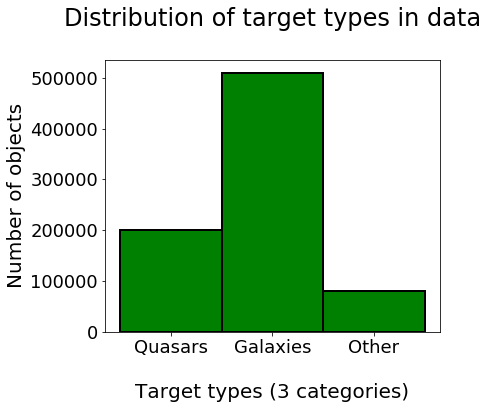

In [25]:
plt.figure(figsize=(6,5))
fig = plt.hist(Y, bins=np.arange(4), align='left', histtype='bar', color="green", ec="black", lw=2)

plt.xticks(np.arange(3),
           labels=['Quasars', 'Galaxies', 'Other'],
           rotation=0, fontsize=18)

plt.yticks(fontsize=18)
plt.ylabel('Number of objects')
plt.xlabel('\nTarget types (3 categories)')
plt.title('Distribution of target types in data\n')

plt.savefig('Images/Histogram_categories.eps',
            format="eps", bbox_inches='tight')
plt.show()